# Text classification with Huggingface transformers

Be sure to have Persistence set to an option including "Files" when swapping between CPU/GPU to use as little of the GPU quota as possible and still share objects between sessions.

Other useful materials:
-  https://karpathy.github.io/2019/04/25/recipe/

In [21]:
from pathlib import Path
from datasets import load_dataset
import pandas as pd
from transformers import AutoModel
import torch
from torch import Tensor
from datasets import load_from_disk
from typing import List, Dict
from transformers import AutoTokenizer
from datasets import list_datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [22]:
list_datasets()[:10]

['acronym_identification',
 'ade_corpus_v2',
 'adversarial_qa',
 'aeslc',
 'afrikaans_ner_corpus',
 'ag_news',
 'ai2_arc',
 'air_dialogue',
 'ajgt_twitter_ar',
 'allegro_reviews']

Let's explore the `emotion` dataset

In [23]:
emotions = load_dataset('SetFit/emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/SetFit--emotion-ddb0f0516f8def09/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Note that `load_dataset` can also be used to load local datasets.

In [24]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

We can get dataset splits with itemgetter syntax

In [25]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 16000
})

In [26]:
type(train_ds)

datasets.arrow_dataset.Dataset

This is an Arrow dataset

In [27]:
len(train_ds)

16000

In [28]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}

In [29]:
train_ds.column_names

['text', 'label', 'label_text']

In [30]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'label_text': Value(dtype='string', id=None)}

In [31]:
train_ds[:3]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong'],
 'label': [0, 0, 3],
 'label_text': ['sadness', 'sadness', 'anger']}

We can also slice particular columns

In [32]:
train_ds['text'][:3]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong']

## From `Dataset`s to `DataFrame`s

Huggingface transformers provides an API to convert the *output* of a `Dataset` object to a Pandas `DataFrame`, whilst retaining the underlying data format of an Arrow table. This can be useful for e.g. visualisation.

In [33]:
emotions.set_format(type='pandas')
df = emotions['train'][:]

In [34]:
df

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


## Visualize the class distribution

<AxesSubplot:>

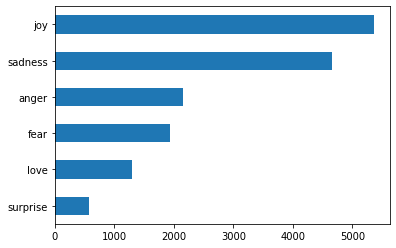

In [35]:
df['label_text'].value_counts(ascending=True).plot.barh()

To deal with imbalance, we can e.g.:
- Undersample over-represented classes
- Oversample under-represented classes
- Reweight the loss with the inverse category frequency

Be sure to only under/over-sample once you've performed a test/train split.

## Visualise token length

In [36]:
df['n_words'] = df['text'].str.split(' ').apply(len)

<AxesSubplot:title={'center':'n_words'}, xlabel='label_text'>

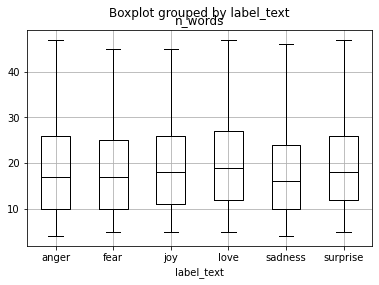

In [37]:
df.boxplot(column='n_words', by='label_text', showfliers=False, whis=(2.5, 97.5), color='black')

No substantial difference in the distribution of lengths

In [38]:
df['n_words'].describe()


count    16000.000000
mean        19.166313
std         10.986905
min          2.000000
25%         11.000000
50%         17.000000
75%         25.000000
max         66.000000
Name: n_words, dtype: float64

The maximum number of words is well below DistilBERT's maximum context size.

When we're done with EDA, we can reset the output format.

In [39]:
emotions.reset_format()

## Tokenization

Character tokenization requires a model to learn how to form words from characters, putting a large burden on the language model. Word tokenization can result in very large vocabularies once you take declinations (?), conjugations, or misspellings into account. Subword tokenization is a more commonly-used middle-ground, and is typically learned from the corpus

We can load the tokenizer associated with a pre-trained model as follows:

In [40]:
model_ckpt = "distilbert-base-uncased"  # checkpoint name
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)  # loads from a model checkpoint

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

We could've also used
```python
from transformers import DistilBertTokenizer
DistilBertTokenizer.from_pretrained(model_ckpt)
```

In [41]:
text = "Tokenizing text is (currently) a core task of NLP."

In [42]:
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1006, 2747, 1007, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

(We'll talk about `attention_mask` later)

In [43]:
len(encoded_text['input_ids']), len(text.split(' '))

(16, 9)

We can see how the tokenizer split the subwords up as follows:

In [44]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 '(',
 'currently',
 ')',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

- The `[CLS]` and `[SEP]` tokens will vary from model to model, but their purpose is to indicate the start/end of a sequence
- The tokens are all lowercased
- "tokenizing" and "NLP" have been split into separate tokens, because they are not common words
- The `##` prefix means that the preceding characters are not whitespace and indicates the need to merge with the preceding token

In [45]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is ( currently ) a core task of nlp. [SEP]'

The tokenizer also contains metadata

In [46]:
tokenizer.vocab_size

30522

In [47]:
tokenizer.model_max_length

512

The model requires the following fields from the tokenizer:

In [48]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

## Tokenizing an entire dataset

In [49]:
emotions["train"][:2]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'],
 'label': [0, 0],
 'label_text': ['sadness', 'sadness']}

In [50]:
def tokenize(batch: Dict[str, List]):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [51]:
tokenize(emotions["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

We can see that the attention masks are zero-ing out the padding tokens.

We can now apply the `tokenize` function across all the splits of the corpus

In [52]:
# Using batched=True and batch_size=None will tokenize the entire dataset as a single batch, ensuring that 
# all sequences are padded to the same length
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [53]:
emotions_encoded["train"].column_names

['text', 'label', 'label_text', 'input_ids', 'attention_mask']

Models like DistilBERT are pretrained to predict masked words in a sequence of text. If we're interested in doing a classification task, we need to either perform:
- Feature extraction: Use the hidden states of the encoder block and train a classifier directly on those vectors
- Fine-tuning: Train the whole model end-to-end for the new task

## Transformers as feature extractors

We freeze the model and then can e.g. feed the features to a model like a gradient-boosting decision tree, or train a small neural classification layer.

We'll use another auto class from huggingface for this:

In [70]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

### Extracting the hidden states

In [71]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")  # return pytorch tensors
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [72]:
def extract_hidden_states(batch: Dict[str, Tensor]):
    # place model inputs on the device
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    
    # Extract last hidden states
    with torch.no_grad():  # don't compute the gradient -- we're just doing inference
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token (this is common practice)
    # Otherwise we'd have a vector for every token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [73]:
outputs = extract_hidden_states(inputs)
outputs['hidden_state'].shape

(1, 768)

To apply the above function on the whole dataset, we'll need to convert the `label`, `input_ids` and `attention_mask` to `torch` format

In [74]:
emotions_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

In [75]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [76]:
emotions_hidden['train'].column_names  # we now have a hidden state

['text', 'label', 'label_text', 'input_ids', 'attention_mask', 'hidden_state']

In [77]:
# Must have Persistence to include files or this won't keep any files after restarting the session
emotions_hidden.save_to_disk('/kaggle/working/emotions_hidden')

In [78]:
# Must have Persistence to include files or this won't see any files 
emotions_hidden = load_from_disk('/kaggle/working/emotions_hidden')  

In [79]:
emotions_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

## Creating a feature matrix

The approach below of training a classifier on the final hidden state of a large language model doesn't require a GPU, but is less performant than doing fine-tuning.

In [80]:
import numpy as np

In [81]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape,X_valid.shape

((16000, 768), (2000, 768))

### Visualizing hidden states

Let's use UMAP to visualize the training set. UMAP works best on vectors scaled down to the `[0,1]` interval.

In [82]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [83]:
X_scaled = MinMaxScaler().fit_transform(X_train)

In [84]:
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [85]:
df_emb = pd.DataFrame(mapper.embedding_, columns=["u1", "u2"])
df_emb["label"] = y_train
df_emb["label_name"] = emotions["train"]['label_text']
df_emb.head()

,u1,u2,label,label_name
0,4.658544,6.775409,0,sadness
1,-2.643277,5.868299,0,sadness
2,5.480064,3.386267,3,anger
3,-2.141337,3.948127,2,love
4,-3.036624,4.159945,3,anger


In [86]:
# Doesn't work :(
# g = sns.FacetGrid(df_emb, col="label_name")
# g.map_dataframe(sns.jointplot, x="u1", y="u2", kind="hex")

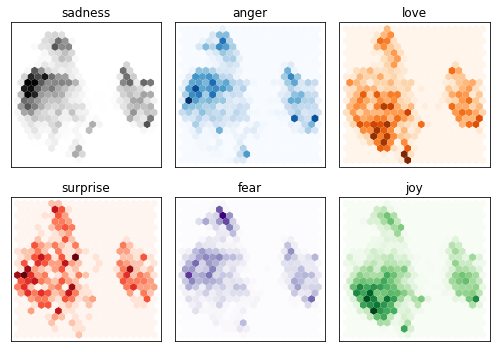

In [87]:
fig, axes = plt.subplots(2, 3, figsize=(7,5), sharex=False)
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]

for i, (label, cmap) in enumerate(zip(df_emb["label_name"].unique(), cmaps)):
    df_emb_sub = df_emb.query(f"label_name == '{label}'")
    axes[i].hexbin(df_emb_sub["u1"], df_emb_sub["u2"], cmap=cmap,
    gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()

Not the clearest result I've seen. I also [don't particularly trust UMAP/tSNE](https://twitter.com/lpachter/status/1431325969411821572?lang=en-GB).

### Train a simple classifier

In [89]:
from sklearn.linear_model import LogisticRegression

In [90]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.634

We can compare this against a dummy classifier

In [91]:
from sklearn.dummy import DummyClassifier

In [92]:
dummy_clf = DummyClassifier(strategy="most_frequent")  # always predict the most frequent class
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [94]:
label_to_name = {r['label']:r['label_name'] for _, r in df_emb[['label', 'label_name']].drop_duplicates().iterrows()}

In [95]:
display_labels = [label_to_name[l] for l in lr_clf.classes_]

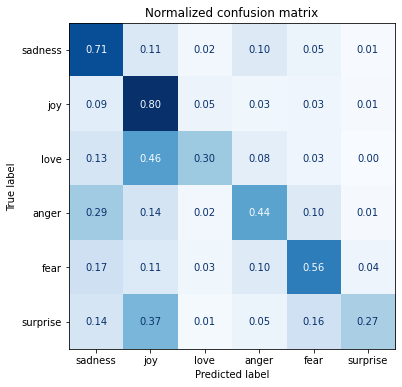

In [96]:
y_preds = lr_clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_preds, normalize="true")
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Normalized confusion matrix")
plt.show()

## Fine-tuning transformers

The approach below will train the entire DistilBERT model. A GPU will probably be needed here -- CPU training will take hours, whereas GPU training will take minutes.

In [56]:
from transformers import AutoModelForSequenceClassification  # similar to AutoModel above, except it has a classification head
from transformers import Trainer, TrainingArguments

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [62]:
num_labels = 6
model_ckpt = "distilbert-base-uncased"
trained_path = f'/kaggle/working/{model_name}/trained'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels = num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

In [63]:
from transformers.trainer import EvalPrediction
from sklearn.metrics import accuracy_score, f1_score

In [64]:
def compute_metrics(pred: EvalPrediction):  # contains predictions and label_ids
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=-1)
    f1 = f1_score(labels, preds, average="weighted")  # to deal with class imbalance
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [65]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f'{model_ckpt}-finetuned-emotion'
training_args = TrainingArguments(
    output_dir=f'/kaggle/working/{model_name}',
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

In [40]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer,
                 )
trainer.train()
trainer.save_model(trained_path)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.839900,0.321364,0.904500,0.902849
2,0.245200,0.217548,0.917500,0.917332


TrainOutput(global_step=500, training_loss=0.5425249328613281, metrics={'train_runtime': 159.0242, 'train_samples_per_second': 201.227, 'train_steps_per_second': 3.144, 'total_flos': 720342861696000.0, 'train_loss': 0.5425249328613281, 'epoch': 2.0})

In [70]:
model = AutoModelForSequenceClassification.from_pretrained(trained_path)

In [71]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer,
                 )

In [104]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [105]:
preds_output.metrics

{'test_loss': 0.21754784882068634,
 'test_accuracy': 0.9175,
 'test_f1': 0.9173315610654035,
 'test_runtime': 2.6286,
 'test_samples_per_second': 760.849,
 'test_steps_per_second': 12.174}

In [106]:
preds_output.predictions.shape

(2000, 6)

In [107]:
y_preds = np.argmax(preds_output.predictions, axis=1)

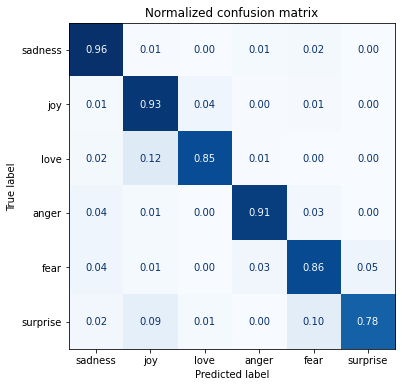

In [108]:
cm = confusion_matrix(y_valid, y_preds, normalize="true")
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Normalized confusion matrix")
plt.show()

This is substantially better than the feature extraction approach.

### Error analysis

Sort the validation samples by model loss, to see where the model gets things the most wrong.

In [68]:
from torch.nn.functional import cross_entropy

In [77]:
def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction='none')
    # Place outputs onto CPU
    return {'loss': loss.cpu().numpy(), 'predicted_label': pred_label.cpu().numpy()}

In [74]:
emotions_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

In [78]:
# compute loss
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [79]:
emotions_encoded.set_format("pandas")

In [107]:
cols = ['text', 'label_text', 'predicted_label', 'loss']
df_valid = emotions_encoded["validation"][:][cols]

In [110]:
label_to_text = {
    r['label']: r['label_text'] for _, r in emotions_encoded['train'][:][['label', 'label_text']].drop_duplicates().iterrows()
}
df_valid['predicted_label'] = df_valid['predicted_label'].map(label_to_text)

Look at examples with greatest loss

In [113]:
from IPython.core.display import display

with pd.option_context('display.max_colwidth', -1):
    display(df_valid.sort_values('loss', ascending=False).head(10))

,text,label_text,predicted_label,loss
1500,i guess we would naturally feel a sense of loneliness even the people who said unkind things to you might be missed,anger,sadness,5.479005
1963,i called myself pro life and voted for perry without knowing this information i would feel betrayed but moreover i would feel that i had betrayed god by supporting a man who mandated a barely year old vaccine for little girls putting them in danger to financially support people close to him,joy,sadness,5.440137
177,im sure much of the advantage is psychological the feeling ive out clevered the competition who are now hopelessly burdened with their big chainring jump,sadness,joy,5.175788
1950,i as representative of everything thats wrong with corporate america and feel that sending him to washington is a ludicrous idea,surprise,sadness,5.041255
1274,i am going to several holiday parties and i can t wait to feel super awkward i am going to several holiday parties and i can t wait to feel super awkward a href http badplaydate,joy,sadness,4.955568
1870,i guess i feel betrayed because i admired him so much and for someone to do this to his wife and kids just goes beyond the pale,joy,sadness,4.928092
1111,im lazy my characters fall into categories of smug and or blas people and their foils people who feel inconvenienced by smug and or blas people,joy,fear,4.627087
882,i feel badly about reneging on my commitment to bring donuts to the faithful at holy family catholic church in columbus ohio,love,sadness,4.374545
1836,i got a very nasty electrical shock when i was tampering with some electrical applainces,fear,anger,4.217661
1964,i feel vaguely cheated and a little amused,joy,anger,4.217200


Some of the joy labels seem wrong or there is no appropriate category.

And smallest loss

In [115]:
with pd.option_context('display.max_colwidth', -1):
    display(df_valid.sort_values('loss', ascending=True).head(10))

,text,label_text,predicted_label,loss
1140,i do think about certain people i feel a bit disheartened about how things have turned out between them it all seems shallow and really just plain bitchy,sadness,sadness,0.016173
244,im kinda relieve but at the same time i feel disheartened,sadness,sadness,0.016205
697,i was missing him desperately and feeling idiotic for missing him,sadness,sadness,0.016533
1452,i always feel guilty and come to one conclusion that stops me emily would be so disappointed in me,sadness,sadness,0.016715
1326,i am feeling neglectful i feel like i should have stayed for a month or two but i could not,sadness,sadness,0.016915
1644,i want a relationship where partners empower each other not feel burdened by their histories and eccentricities,sadness,sadness,0.016921
1656,im feeling very jaded and uncertain about love and all basically im sick of being the one more in love of falling for someone who doesnt feel as much towards me,sadness,sadness,0.016973
1303,i feel pathetic and uninspired,sadness,sadness,0.016976
189,i leave the meeting feeling more than a little disheartened,sadness,sadness,0.016981
1120,i am feeling a little disheartened,sadness,sadness,0.016993


Model seems to be most able to pick out sadness.

## Inference on new data

In [117]:
from transformers import pipeline

In [121]:
clf = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [122]:
custom_tweet = "I saw a movie today and it was really good."

In [123]:
preds = clf(custom_tweet, return_all_scores=True)

/opt/conda/lib/python3.7/site-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


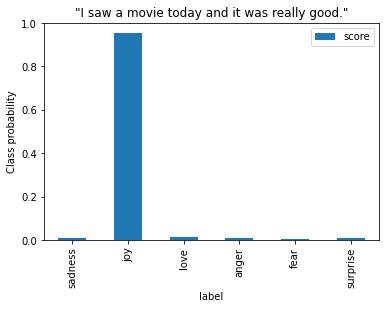

In [135]:
ax = pd.DataFrame({'label': [label_to_text[int(p['label'][-1])] for p in preds], 'score': [p['score'] for p in preds]}).plot(
    x='label',
    y='score',
    kind='bar'
)
ax.set_ylabel("Class probability")
ax.set_title(f'"{custom_tweet}"');